# Solución de Problemas Sergio Alejandro Zamora Dávila
Importo los datos del archivo “Calificaciones.csv” al ambiente de trabajo. Imprimo en consola
el tipo de dato de cada variable del data frame.

In [15]:
import pandas as pd
df = pd.read_csv("Calificaciones.csv")
print(df.dtypes)

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


Para poder obtener un modelo de regresión lineal múltiple es necesario que no haya ninguna variable categórica. Se utiliza "where" y "dtypes==object", de tal forma que se obtendrán todas las variables que tengan valores de tipo objeto y con el "for i in ind" va a ir eliminando esas variables y creando nuevas variables "dummy" que representan a las variables categóricas, pero de una forma que pueda ser usada para la regresión lineal.

Al ver las variables me di cuenta de que aunque la variable "Horas de Estudio" tuviera valores enteros, como el 1, 2, 3 o 4, realmente son categorías en las que se dividen, por lo que es una variable categórica. Debido a esto se creó 3 variables dummy para poder representarlo.

In [16]:
import numpy as np 
ind=np.where(df.dtypes==object)
for i in ind:
      dummy=pd.get_dummies(df.iloc[:,i],drop_first=True)
      df=pd.concat([df,dummy],axis=1)
df=df.drop(labels=df.columns[ind],axis=1)

dummyEstudio=pd.get_dummies(df.HorasDeEstudio,drop_first=True)
df=pd.concat([df,dummyEstudio],axis=1)
df=df.drop("HorasDeEstudio",axis=1)
df.head()

,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,2,3,4
0,18,0,6,5,6,6,False,False,False,True,False,False
1,17,0,4,5,5,6,False,False,True,True,False,False
2,15,3,10,7,8,10,False,False,True,True,False,False
3,15,0,2,15,14,15,False,False,True,False,True,False
4,16,0,4,6,10,10,False,False,False,True,False,False


Utilizando el método de Tukey con k=3 pude identificar los valores atípicos de la variable "Faltas", esto calculando el cuartil 1 (0.25) y el cuartil 3 (0.75), a partir de esos valores se obtiene el iqr, que es la diferencia entre el tercer cuartil y el primero. Utilizando "where" se pueden identificar los índices de las observaciones que son atípicos, teniendo estudiantes desde 38 faltas hasta 75.

In [17]:
q1=df.Faltas.quantile(0.25)
q3=df.Faltas.quantile(0.75)
iqr=q3-q1
li=q1-(3*iqr)
ls=q3+(3*iqr)
out=np.where((df.Faltas<=li) | (df.Faltas>=ls))[0]
print(df.iloc[out,:])

     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
74     16           0      54  11  12  11       False   False          True   
183    17           0      56   9   9   8       False   False          True   
276    18           0      75  10   9   9       False   False          True   
307    19           1      38   8   9   8       False    True          True   
315    19           1      40  13  11  11       False   False          True   

         2      3      4  
74    True  False  False  
183   True  False  False  
276   True  False  False  
307  False  False  False  
315  False   True  False  


Dentro de la variable Faltas tenemos varios valores atípicos, aunque no sean necesariamente errores, son datos demasiado alejados de las demás variables de la base de datos. Es por ello que por temas prácticos y que esos datos no afecten de forma negativa a nuestro modelo decidí cambiar los valores atípicos por un valor calculado en base a los valores "vecinos", uno supondría que se utilizarían todas las variables para poder obtener el valor "hueco" que se tiene, pero esto sería un error. Esto ya que si utilizamos la variable de G3 para calcular el valor esperado de faltas estaríamos cometiendo un sesgo de antemano, ya que como G3 es el valor final (el que queremos predecir) no es una buena práctica utilizarlo para obtener el valor de Faltas, incluso se consideraría como una fuga de datos. Así que para obtener el valor de faltas, se utilizan los valores de los 5 alunmos más parecidos para sacar el nuevo valor. 

In [18]:
from sklearn.impute import KNNImputer

# Asegurar que todos los nombres de columnas sean string
df.columns = df.columns.map(str)

# Aplico KNN para imputar
imputer = KNNImputer(n_neighbors=5)

# Usamos todas las variables excepto G3 (target)
cols = [c for c in df.columns if c != "G3"]

df_knn = df.copy()
df_knn[cols] = imputer.fit_transform(df[cols])

# Reemplazar solo los outliers en "Faltas"
df.loc[out, "Faltas"] = df_knn.loc[out, "Faltas"]


Para poder observar si hay variables que se pueden eliminar para que el modelo cuente con menos variables (lo cuál es mejor), se genera una matriz de correlaciones para poder encontrar potenciales problemas de colinealidad. Se genera un Heatmap para la fácil visualización de los resultados. 

4 5
0.9048679892693002


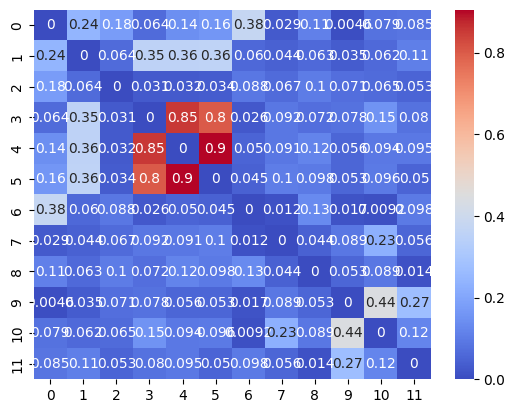

In [19]:
cor = df.corr().abs().to_numpy()
np.fill_diagonal(cor, 0)
i, j = np.unravel_index(cor.argmax(), cor.shape)
print(i, j)
print(cor[i, j])

from seaborn import heatmap
import matplotlib.pyplot as plt

heatmap(cor, annot=True, cmap="coolwarm")
plt.show()


Como podemos ver en el Heatmap hay 3 relaciones que tienen valores muy altos, la variable 3 con la 5, la 3 con la 4 y la 4 con la 5, en pocas palabras las variables de las calificaciones, primer parcial, segundo parcial y final tienen una relación muy alta, lo cuál tiene mucho sentido, pero como nuestro objetivo es calcular el promedio final, entonces no tendría sentido eliminar esta variable. Tampoco considero de mucha utilidad eliminar ya sea la calificación del primer o de segundo parcial, ya que aunque tengan una relación alta ambas son variables independientes y considero que el modelo empeoraría si se elimina algúna de ellas, por lo que en este caso no creo que sea necesario eliminar variables. 

Se han creado 2 nuevas variables a causa de la relación de otras, se ha creado la variable "SexoM_Faltas", la cuál conbina la información del Sexo_M y las Faltas. La otra variable que se añadió es la de "Internet_Reprobadas", la cuál viene de la relación de entre "Internet_yes" y "Reprobadas".

In [20]:
df.columns = df.columns.map(str)
df["SexoM_Faltas"] = df["Sexo_M"].astype(int) * df["Faltas"]
df['Internet_Reprobadas'] = df['Internet_yes'] * df['Reprobadas']
df.head(5)

,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,2,3,4,SexoM_Faltas,Internet_Reprobadas
0,18,0,6,5,6,6,False,False,False,True,False,False,0,0
1,17,0,4,5,5,6,False,False,True,True,False,False,0,0
2,15,3,10,7,8,10,False,False,True,True,False,False,0,3
3,15,0,2,15,14,15,False,False,True,False,True,False,0,0
4,16,0,4,6,10,10,False,False,False,True,False,False,0,0


Como último paso se entrena un modelo de regresión lineal múltiple en un subconjunto de datos que corresponde al 80 por ciento de los datos totales, esto ya que el otro 20 por ciento será utilizado para evaluar la calidad del modelo creado. Con los datos obtenidos se genera una gráfica de dispersión de las calificaciones finales reales vs las que se estimaron utilizando el modelo.

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     125.0
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          4.53e-113
Time:                        07:30:05   Log-Likelihood:                -636.68
No. Observations:                 316   AIC:                             1301.
Df Residuals:                     302   BIC:                             1354.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.8098    

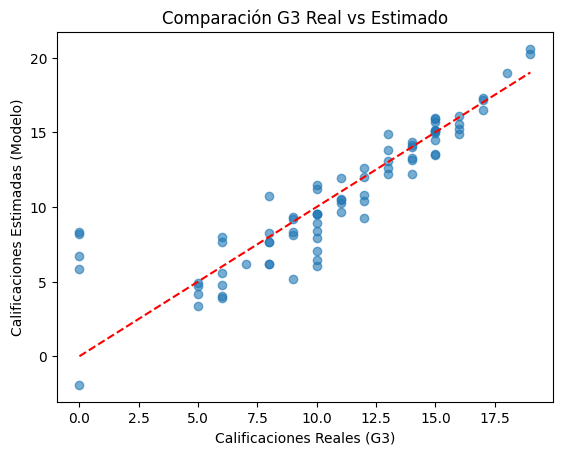

In [21]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(df.drop("G3",axis=1), df.G3, train_size=0.8, random_state=42)

# Tenia errores de dtype = object o bool, así que lo converti todo a float 
X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

modelo = sm.OLS(Y_train, X_train_const).fit()

print(modelo.summary())

y_pred = modelo.predict(X_test_const)

plt.scatter(Y_test, y_pred, alpha=0.6)
plt.xlabel("Calificaciones Reales (G3)")
plt.ylabel("Calificaciones Estimadas (Modelo)")
plt.title("Comparación G3 Real vs Estimado")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], "r--")  
plt.show()


El modelo de regresión lineal múltiple explica aproximadamente el 85% de la variabilidad en la calificación final (R² = 0.848), lo que es un buen porcentaje de poder predictivo. De entre las variables más significativas están las calificaciones de parcial G1 y especialmente G2, que tienen un efecto positivo fuerte sobre G3. Lo que significa que si te va bien en tu primer parcial y si te va bien en tu segundo parcial (en especial el segundo parcial), puedo decir con un 85 por ciento de certeza que te va a ir bien en tu calificación final. Por otro lado, factores como edad y materias reprobadas tienen un efecto negativo en las calificaciones, mientras que variables como escuela, sexo e internet no resultaron estadísticamente significativas.